In [1]:
import numpy as np
import pandas as pd

In [2]:
model_names = [
    'rawpredictions/glove_0.csv',
    'rawpredictions/glove_1.csv',
    'rawpredictions/glove_2.csv',
    'rawpredictions/glove_3.csv',
    'rawpredictions/glove_4.csv',
    'rawpredictions/glove_5.csv',
    'rawpredictions/glove_6.csv',
    'rawpredictions/glove_7.csv',
    'rawpredictions/glove_8.csv',
    'rawpredictions/glove_9.csv',
]
nmodels = len(model_names)

In [3]:
for i in range(nmodels):
    if i == 0:
        df = pd.read_csv(model_names[i])
        df['prediction_0'] = np.log(df.prediction / (1 - df.prediction))
        df.drop('prediction', axis=1, inplace=True)
    else:
        df_temp = pd.read_csv(model_names[i])
        df_temp.prediction = np.log(df_temp.prediction / (1 - df_temp.prediction))
        df['prediction_' + str(i)] = df_temp.prediction
    print('loaded', i)

loaded 0
loaded 1
loaded 2
loaded 3
loaded 4
loaded 5
loaded 6
loaded 7
loaded 8
loaded 9


In [19]:
df['prediction'] = df.loc[:, 'prediction_0':'prediction_9'].mean(axis=1)

In [20]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df.query('validation_set == 10').reordered, df.query('validation_set == 10').prediction)

0.83814171500047585

In [27]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

X_train = df.loc[df.validation_set == 10, 'prediction_0':('prediction_' + str(nmodels-1))].as_matrix()
y_train = df.loc[df.validation_set == 10, 'reordered'].as_matrix()
X_oldtrain = df.loc[(df.validation_set > -1) & (df.validation_set < 10), 'prediction_0':('prediction_' + str(nmodels-1))].as_matrix()
y_oldtrain = df.loc[(df.validation_set > -1) & (df.validation_set < 10), 'reordered'].as_matrix()
X_test = df.loc[df.validation_set == -1, 'prediction_0':('prediction_' + str(nmodels-1))].as_matrix()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_oldtrain = scaler.transform(X_oldtrain)
X_test = scaler.transform(X_test)

In [21]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

X_train = df.loc[df.validation_set == 10, ['prediction_mean_1', 'prediction_mean_2']].as_matrix()
y_train = df.loc[df.validation_set == 10, 'reordered'].as_matrix()
X_oldtrain = df.loc[(df.validation_set > -1) & (df.validation_set < 10), ['prediction_mean_1', 'prediction_mean_2']].as_matrix()
y_oldtrain = df.loc[(df.validation_set > -1) & (df.validation_set < 10), 'reordered'].as_matrix()
X_test = df.loc[df.validation_set == -1, ['prediction_mean_1', 'prediction_mean_2']].as_matrix()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_oldtrain = scaler.transform(X_oldtrain)
X_test = scaler.transform(X_test)

In [169]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(include_bias=False)


In [170]:
X_train = poly.fit_transform(X_train)
X_oldtrain = poly.transform(X_oldtrain)
X_test = poly.transform(X_test)

In [171]:
X_train = np.array([X_train[:,:nmodels].mean(axis=1), X_train[:,nmodels:].mean(axis=1)]).transpose()
X_oldtrain = np.array([X_oldtrain[:,:nmodels].mean(axis=1), X_oldtrain[:,nmodels:].mean(axis=1)]).transpose()
X_test = np.array([X_test[:,:nmodels].mean(axis=1), X_test[:,nmodels:].mean(axis=1)]).transpose()

In [28]:
model = LogisticRegressionCV(Cs=[1, .1, .001, .0001], cv=5)

model.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1, 0.1, 0.001, 0.0001], class_weight=None, cv=5,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [15]:
X_train

array([[ 3.61179039,  3.64322731],
       [ 1.88120344,  1.86491656],
       [ 0.59309404,  0.62722595],
       ..., 
       [-0.7662714 , -1.00087056],
       [-1.64066516, -0.29462404],
       [-0.75973076,  0.08058768]])

In [29]:
model.C_

array([ 0.001])

In [30]:
model.coef_

array([[ 0.13686583,  0.15958202,  0.14730216,  0.11807444,  0.126903  ,
         0.12821553,  0.13912959,  0.14703284,  0.17956682,  0.15539243,
         0.00343299, -0.00793968,  0.01048113, -0.01995246, -0.01748667,
        -0.00111287,  0.02039834,  0.01599443, -0.00168831, -0.00870126]])

In [31]:
model.intercept_

array([-2.96522015])

In [32]:
model.scores_[1.0].mean(0).max()

0.91099879207137691

In [34]:
((df.query('validation_set==10').prediction_mean_1 > 0).astype(int) == df.query('validation_set==10').reordered).mean()

0.88001155469461756

In [41]:
df.head(10)

,eval_set,validation_set,order_id,product_id,user_id,user_distinct_products,reordered,prediction_0,prediction_1,prediction_2,...,prediction_13,prediction_14,prediction_15,prediction_16,prediction_17,prediction_18,prediction_19,user_mean_proportion_products,prediction_mean_1,prediction_mean_2
0,train,10.0,1187899,196,1,18,1.0,2.126524,2.309080,2.310206,...,2.156211,2.169453,2.092936,2.251295,2.179759,2.147182,2.605162,0.327778,2.210116,2.245948
1,test,-1.0,363822,196,8942,38,0.0,-0.986852,-1.124786,-1.128720,...,-1.220835,-0.908814,-1.182434,-1.210910,-1.143323,-1.347630,-1.266388,0.368421,-1.088746,-1.179716
2,train,3.0,1071098,196,11192,37,0.0,-2.124843,-2.137244,-1.759599,...,-2.395121,-2.205188,-2.424759,-2.058052,-2.445142,-2.292393,-2.425807,0.247104,-2.185613,-2.386210
3,train,8.0,1339982,196,12100,4,1.0,0.581615,0.859751,0.463173,...,0.790328,0.521644,0.578848,0.785813,0.602138,0.770129,0.211298,0.678571,0.600398,0.598871
4,test,-1.0,391840,196,24280,14,0.0,-3.326132,-3.232276,-3.318604,...,-3.546408,-3.401035,-3.542811,-3.161018,-3.662535,-3.210860,-3.288684,0.107143,-3.349844,-3.372631
5,train,4.0,1288958,196,25303,141,0.0,-0.729874,-0.891646,-0.902179,...,-1.049538,-0.790003,-0.905433,-0.856741,-0.522171,-1.068237,-1.080593,0.216706,-0.933019,-0.854929
6,train,8.0,2644818,196,26923,21,0.0,-2.617576,-2.524278,-2.629315,...,-2.518082,-2.519861,-2.586874,-2.378808,-2.499528,-2.315845,-2.370624,0.168831,-2.613038,-2.495566
7,train,1.0,431927,196,33574,16,1.0,1.300373,1.654618,1.519326,...,1.606295,1.378853,1.499313,1.350047,1.393831,1.518397,1.814141,0.218750,1.500460,1.525914
8,test,-1.0,3254668,196,34207,4,0.0,-0.462210,-0.244321,-0.136170,...,-0.518416,-0.080682,-0.168282,0.033417,0.036424,0.026860,-0.199117,0.416667,-0.235748,-0.090234
9,test,-1.0,3144266,196,42970,12,0.0,-0.535354,-0.684939,-0.900526,...,-0.940067,-1.010225,-0.842308,-1.053341,-0.969800,-1.168491,-0.963841,0.444444,-0.752590,-1.015114


In [15]:
#df['model_prediction'] = 0
#df.loc[df.validation_set == 10, 'model_prediction'] = model.decision_function(X_train)
#df.loc[(df.validation_set > -1) & (df.validation_set < 10), 'model_prediction'] = model.decision_function(X_oldtrain)
#df.loc[df.validation_set == -1, 'model_prediction'] = model.decision_function(X_test)


In [16]:
#df['model_prob'] = 0
#df.loc[df.validation_set == 10, 'model_prob'] = model.predict_proba(X_train)[:,1]
#df.loc[(df.validation_set > -1) & (df.validation_set < 10), 'model_prob'] = model.predict_proba(X_oldtrain)[:,1]
#df.loc[df.validation_set == -1, 'model_prob'] = model.predict_proba(X_test)[:,1]


In [17]:
#df['user_ump_logit'] = np.log((.01 + .98 * df.user_mean_proportion_products) / (1 - (.01 + .98 * df.user_mean_proportion_products)))

In [18]:
#df['prediction_avg'] = df.loc[:, 'prediction_0':'prediction_9'].mean(axis=1)

In [21]:
df['prob'] = 1.0 / (1 + np.exp(-df.prediction))

In [22]:
df.head()

,eval_set,validation_set,order_id,product_id,user_id,user_distinct_products,reordered,prediction_0,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6,prediction_7,prediction_8,prediction_9,prediction,prob
0,train,10.0,1187899,196,1,18,1.0,2.126524,2.309080,2.310206,2.260471,2.163989,2.294375,2.104397,2.265535,2.042809,2.223769,2.210116,0.901154
1,test,-1.0,363822,196,8942,38,0.0,-0.986852,-1.124786,-1.128720,-1.094986,-1.178340,-0.954015,-1.037039,-1.141195,-1.245290,-0.996234,-1.088746,0.251855
2,train,3.0,1071098,196,11192,37,0.0,-2.124843,-2.137244,-1.759599,-2.054594,-2.436596,-2.329345,-2.357051,-2.352092,-2.232696,-2.072072,-2.185613,0.101050
3,train,8.0,1339982,196,12100,4,1.0,0.581615,0.859751,0.463173,0.467443,0.696789,0.454466,0.809707,0.330569,0.813737,0.526730,0.600398,0.645747
4,test,-1.0,391840,196,24280,14,0.0,-3.326132,-3.232276,-3.318604,-2.899490,-3.605042,-3.493843,-4.063761,-3.115214,-3.414773,-3.029308,-3.349844,0.033900


In [20]:
df['p_not'] = 1 - df.model_prob

In [59]:
none_df = pd.read_csv('rawpredictions/nones.csv')
none_df['none_prob'] = none_df.prediction

In [22]:
df = df.merge(none_df[['user_id', 'none_prob']], on='user_id')

In [61]:
probs = df.query('user_id == 10')['model_prob'].values

In [69]:
noneprob = df.query('user_id == 10')['none_prob'].values[0]

In [138]:
none_df.none_prob.mean()

0.065092411300815778

0.041714959094898862

In [71]:
base_pnot = np.prod(1-probs)

In [76]:
extra_none = 0
newprobs = probs.copy()
while extra_none + (1-extra_none) * np.prod(1-newprobs) < noneprob:
    extra_none = extra_none + .0001
    newprobs = np.minimum(probs / (1 - extra_none), 1)

In [77]:
extra_none

0.024599999999999907

In [82]:
probs = newprobs

In [95]:
nsamples = 100000
samples = (np.random.rand(nsamples, probs.shape[0]) < probs * np.ones((nsamples, probs.shape[0]))).astype(int)

In [99]:
samples[:np.random.binomial(nsamples, extra_none),:] = 0

In [100]:
samples

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 1, 0]])

In [125]:
samples = np.concatenate((samples, (samples.sum(1) == 0).astype(int).reshape((nsamples, 1))), axis=1)

In [126]:
samples.shape

(100000, 19)

In [127]:
sums = samples.sum(1) - 1

In [128]:
P = np.zeros((probs.shape[0] + 1, probs.shape[0] + 1))

In [129]:
for i in range(nsamples):
    P[:, sums[i]] = P[:, sums[i]] + samples[i, :]

In [131]:
P = P / nsamples

In [134]:
W = np.zeros(P.shape)

In [136]:
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        W[i, j] = 1.0 / (i + j + 2.0)

In [138]:
F = np.dot(P, W)

In [158]:
m = P.shape[0]
expectedF1s = np.zeros((m))
for k in range(m):
    f = F[:,k]
    h = np.zeros((m))
    h[np.flip(np.argsort(f), axis=0)[:(k+1)]] = 1
    expectedF1s[k] = 2 * np.dot(h, f)
k = np.argmax(expectedF1s)
expF1 = expectedF1s[k]
f = F[:,k]
prediction = np.zeros((m))
prediction[np.flip(np.argsort(f), axis=0)[:(k+1)]] = 1


In [31]:
def GFM(df, nsamples=10000):
    probs = df['prob'].values
    noneprob = df['none_prob'].values[0]
    extra_none = 0
    newprobs = probs.copy()
    while extra_none + (1-extra_none) * np.prod(1-newprobs) < noneprob:
        extra_none = extra_none + .0001
        newprobs = np.minimum(probs / (1 - extra_none), 1)
    probs = newprobs
    samples = (np.random.rand(nsamples, probs.shape[0]) < probs * np.ones((nsamples, probs.shape[0]))).astype(int)
    samples[:np.random.binomial(nsamples, extra_none),:] = 0
    samples = np.concatenate((samples, (samples.sum(1) == 0).astype(int).reshape((nsamples, 1))), axis=1)
    sums = samples.sum(1) - 1
    P = np.zeros((probs.shape[0] + 1, probs.shape[0] + 1))
    for i in range(nsamples):
        P[:, sums[i]] = P[:, sums[i]] + samples[i, :]
    P = P / nsamples
    W = np.zeros(P.shape)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i, j] = 1.0 / (i + j + 2.0)
    F = np.dot(P, W)
    m = P.shape[0]
    expectedF1s = np.zeros((m))
    for k in range(m):
        f = F[:,k]
        h = np.zeros((m))
        h[np.flip(np.argsort(f), axis=0)[:(k+1)]] = 1
        expectedF1s[k] = 2 * np.dot(h, f)
    k = np.argmax(expectedF1s)
    expF1 = expectedF1s[k]
    f = F[:,k]
    prediction = np.zeros((m))
    prediction[np.flip(np.argsort(f), axis=0)[:(k+1)]] = 1
    df['prediction'] = prediction[:-1]
    df['putnone'] = prediction[-1]
    df['expF1'] = expF1
    return df

In [75]:
test_df = df.query('validation_set==10').loc[:, ['user_id', 'product_id', 'order_id', 'prob', 'none_prob', 'reordered']].copy()


In [76]:
test_df.shape

(765057, 6)

In [77]:
%%time
test_df = test_df.groupby('user_id').apply(GFM)

CPU times: user 3h 33min 39s, sys: 5min 17s, total: 3h 38min 56s
Wall time: 21min 16s


In [78]:
gfm_df = test_df

In [79]:
gfm_df['hit'] = gfm_df.prediction * gfm_df.reordered
gfm_df_agg = gfm_df.groupby('user_id').agg({'reordered': np.sum,
                                    'prediction': np.sum,
                                    'hit': np.sum,
                               'expF1': np.mean,
                               'putnone': np.mean})
gfm_df_agg['truenone'] = (gfm_df_agg.reordered == 0)
gfm_df_agg.putnone = gfm_df_agg.putnone.astype(bool)
gfm_df_agg['r'] = gfm_df_agg.reordered
gfm_df_agg['p'] = gfm_df_agg.prediction
gfm_df_agg['h'] = gfm_df_agg.hit
gfm_df_agg.loc[gfm_df_agg.putnone & gfm_df_agg.truenone, "h"] = 1
gfm_df_agg.loc[gfm_df_agg.putnone, 'p'] = gfm_df_agg.loc[gfm_df_agg.putnone, 'p'] + 1
gfm_df_agg.loc[gfm_df_agg.truenone, 'r'] = gfm_df_agg.loc[gfm_df_agg.truenone, 'r'] + 1
gfm_df_agg['precision'] = (gfm_df_agg['h']) / (gfm_df_agg['p'])
gfm_df_agg['recall'] = (gfm_df_agg['h']) / (gfm_df_agg['r'])
gfm_df_agg['f1'] = 2 * gfm_df_agg['precision'] * gfm_df_agg['recall'] / (gfm_df_agg['precision'] + gfm_df_agg['recall'] + .000001)


In [80]:
gfm_df_agg.f1.mean()

0.39740466341362979

In [81]:
gfm_df_agg.expF1.mean()

0.40801646884077508

In [216]:
gfm_df_agg.putnone = gfm_df_agg.putnone.astype(bool)

In [140]:
(df.groupby('user_id').agg({'reordered': np.sum}) > 0).mean()

reordered    0.594576
dtype: float64

In [ ]:
threshold_df = df.loc[df.eval_set == 'train', ['user_id', 'user_distinct_products', 'user_mean_proportion_products', 'user_ump_logit', 'model_prediction', 'p_not', 'reordered']].copy()

guess = [-.8, -.1, .4, -1.0]
width = np.array([.2, .1, .2, .1])
best_reorder_cutoff = (0, 0)
best_none_cutoff = (0, 0)
best_cutoff_f1 = 0
for i in range(4):
    for reorder_cutoff in [(x,y) for x in np.arange(guess[0]-4*width[0], guess[0]+4*width[0], width[0]) for y in np.arange(guess[1]-4*width[1], guess[1]+4*width[1], width[1])]:
        threshold_df['reorder_cutoff'] = reorder_cutoff[0] + reorder_cutoff[1] * np.log(threshold_df.user_distinct_products)
        threshold_df.loc[:,'prediction'] = 1 * (threshold_df['model_prediction'] > threshold_df.reorder_cutoff)
        threshold_df['hit'] = (threshold_df.reordered * threshold_df.prediction)
        threshold_df_agg = threshold_df.groupby("user_id").agg({'reordered': np.sum,
                                                          'prediction': np.sum,
                                                          'hit': np.sum,
                                                              'user_distinct_products': np.mean,
                                                             'p_not': np.prod})
        for none_cutoff in [(x,y) for x in np.arange(guess[2]-4*width[2], guess[2]+4*width[2], width[2]) for y in np.arange(guess[3]-4*width[3], guess[3]+4*width[3], width[3])]:
            threshold_df_agg['none_cutoff'] = 1.0 / (1 + np.exp(-none_cutoff[0] - none_cutoff[1] * np.log(threshold_df_agg.user_distinct_products)))
            threshold_df_agg['putnone'] = (threshold_df_agg.p_not > threshold_df_agg.none_cutoff) | (threshold_df_agg.prediction == 0)
            threshold_df_agg['truenone'] = (threshold_df_agg.reordered == 0)
            threshold_df_agg['r'] = threshold_df_agg.reordered
            threshold_df_agg['p'] = threshold_df_agg.prediction
            threshold_df_agg['h'] = threshold_df_agg.hit
            threshold_df_agg.loc[threshold_df_agg.putnone & threshold_df_agg.truenone, "h"] = 1
            threshold_df_agg.loc[threshold_df_agg.putnone, 'p'] = threshold_df_agg.loc[threshold_df_agg.putnone, 'p'] + 1
            threshold_df_agg.loc[threshold_df_agg.truenone, 'r'] = threshold_df_agg.loc[threshold_df_agg.truenone, 'r'] + 1
            threshold_df_agg['precision'] = (threshold_df_agg['h']) / (threshold_df_agg['p'])
            threshold_df_agg['recall'] = (threshold_df_agg['h']) / (threshold_df_agg['r'])
            threshold_df_agg['f1'] = 2 * threshold_df_agg['precision'] * threshold_df_agg['recall'] / (threshold_df_agg['precision'] + threshold_df_agg['recall'] + .000001)
            if threshold_df_agg['f1'].mean() > best_cutoff_f1:
                best_cutoff_f1 = threshold_df_agg['f1'].mean()
                best_reorder_cutoff = reorder_cutoff
                best_none_cutoff = none_cutoff
    guess = [best_reorder_cutoff[0], best_reorder_cutoff[1], best_none_cutoff[0], best_none_cutoff[1]]
    width = width / 4
print("best reorder cutoff:", best_reorder_cutoff)
print("best none cutoff:", best_none_cutoff)
print("best f1:", best_cutoff_f1)


best reorder cutoff: (-1.203125, -0.062500000000000111)
best none cutoff: (0.25625000000000003, -0.94843750000000016)
best f1: 0.40753730298


In [17]:
best_reorder_cutoff = (-1.203125, -0.062500000000000111)
best_none_cutoff = (0.25625000000000003, -0.94843750000000016)

In [32]:
def evaluate_numeric_gradient(objFun, params, step=.05):
    gradient = []
    for i in range(len(params)):
        p1 = params.copy()
        p1[i] = p1[i] - step/2
        p2 = params.copy()
        p2[i] = p2[i] + step/2
        gradient.append((objFun(p2)-objFun(p1))/step)
    return np.array(gradient)

def gradient_ascent(objFun, starting_params, alpha=.1, nrounds=30):
    params = np.array(starting_params)
    for i in range(nrounds):
        print(objFun(params))
        gradient = evaluate_numeric_gradient(objFun, params)
        print(params, gradient)
        params = params + alpha*gradient
    return params
        

In [33]:
def f1_distinct_orders(params):
    threshold_df['reorder_cutoff'] = params[0] + params[1] * np.log(threshold_df.user_distinct_products)
    threshold_df['prediction'] = 1 * (threshold_df['model_prediction'] > threshold_df.reorder_cutoff)
    threshold_df['hit'] = (threshold_df.reordered * threshold_df.prediction)
    threshold_df_agg = threshold_df.groupby("user_id").agg({'reordered': np.sum,
                                                      'prediction': np.sum,
                                                      'hit': np.sum,
                                                        'user_ump_logit': np.mean,
                                                            'user_mean_proportion_products': np.mean,
                                                        'user_distinct_products': np.mean,
                                                         'p_not': np.prod})
    threshold_df_agg['none_cutoff'] = 1.0 / (1 + np.exp(-params[2] - params[3] * np.log(threshold_df.user_distinct_products)))
    threshold_df_agg['putnone'] = (threshold_df_agg.p_not > threshold_df_agg.none_cutoff) | (threshold_df_agg.prediction == 0)
    threshold_df_agg['truenone'] = (threshold_df_agg.reordered == 0)
    threshold_df_agg['r'] = threshold_df_agg.reordered
    threshold_df_agg['p'] = threshold_df_agg.prediction
    threshold_df_agg['h'] = threshold_df_agg.hit
    threshold_df_agg.loc[threshold_df_agg.putnone & threshold_df_agg.truenone, "h"] = 1
    threshold_df_agg.loc[threshold_df_agg.putnone, 'p'] = threshold_df_agg.loc[threshold_df_agg.putnone, 'p'] + 1
    threshold_df_agg.loc[threshold_df_agg.truenone, 'r'] = threshold_df_agg.loc[threshold_df_agg.truenone, 'r'] + 1
    threshold_df_agg['precision'] = (threshold_df_agg['h']) / (threshold_df_agg['p'])
    threshold_df_agg['recall'] = (threshold_df_agg['h']) / (threshold_df_agg['r'])
    threshold_df_agg['f1'] = 2 * threshold_df_agg['precision'] * threshold_df_agg['recall'] / (threshold_df_agg['precision'] + threshold_df_agg['recall'] + .000001)
    return threshold_df_agg['f1'].mean()

def f1_mean_orders(params):
    threshold_df['reorder_cutoff'] = params[0] + params[1] * threshold_df.user_ump_logit
    threshold_df['prediction'] = 1 * (threshold_df['model_prediction'] > threshold_df.reorder_cutoff)
    threshold_df['hit'] = (threshold_df.reordered * threshold_df.prediction)
    threshold_df_agg = threshold_df.groupby("user_id").agg({'reordered': np.sum,
                                                      'prediction': np.sum,
                                                      'hit': np.sum,
                                                        'user_ump_logit': np.mean,
                                                            'user_mean_proportion_products': np.mean,
                                                        'user_distinct_products': np.mean,
                                                         'p_not': np.prod})
    threshold_df_agg['none_cutoff'] = 1.0 / (1 + np.exp(-params[2] - params[3] * threshold_df.user_ump_logit))
    threshold_df_agg['putnone'] = (threshold_df_agg.p_not > threshold_df_agg.none_cutoff) | (threshold_df_agg.prediction == 0)
    threshold_df_agg['truenone'] = (threshold_df_agg.reordered == 0)
    threshold_df_agg['r'] = threshold_df_agg.reordered
    threshold_df_agg['p'] = threshold_df_agg.prediction
    threshold_df_agg['h'] = threshold_df_agg.hit
    threshold_df_agg.loc[threshold_df_agg.putnone & threshold_df_agg.truenone, "h"] = 1
    threshold_df_agg.loc[threshold_df_agg.putnone, 'p'] = threshold_df_agg.loc[threshold_df_agg.putnone, 'p'] + 1
    threshold_df_agg.loc[threshold_df_agg.truenone, 'r'] = threshold_df_agg.loc[threshold_df_agg.truenone, 'r'] + 1
    threshold_df_agg['precision'] = (threshold_df_agg['h']) / (threshold_df_agg['p'])
    threshold_df_agg['recall'] = (threshold_df_agg['h']) / (threshold_df_agg['r'])
    threshold_df_agg['f1'] = 2 * threshold_df_agg['precision'] * threshold_df_agg['recall'] / (threshold_df_agg['precision'] + threshold_df_agg['recall'] + .000001)
    return threshold_df_agg['f1'].mean()

In [35]:
#threshold_df = df.loc[df.eval_set == 'train', ['user_id', 'user_distinct_products', 'user_mean_proportion_products', 'user_ump_logit', 'model_prediction', 'p_not', 'reordered']].copy()
#threshold_df['user_distinct_products_log_scaled'] = StandardScaler().fit_transform(np.log(threshold_df.user_distinct_products))

/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [37]:
#threshold_df['user_ump_scaled'] = StandardScaler().fit_transform(threshold_df.user_ump_logit)

/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/alex/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [34]:
params = [-1.52396524, 0,  -1, 0]
threshold_df['reorder_cutoff'] = params[0] + params[1] * np.log(threshold_df.user_distinct_products)
threshold_df['prediction'] = 1 * (threshold_df['model_prediction'] > threshold_df.reorder_cutoff)
threshold_df['hit'] = (threshold_df.reordered * threshold_df.prediction)
threshold_df_agg = threshold_df.groupby("user_id").agg({'reordered': np.sum,
                                                  'prediction': np.sum,
                                                  'hit': np.sum,
                                                    'user_ump_logit': np.mean,
                                                        'user_mean_proportion_products': np.mean,
                                                    'user_distinct_products': np.mean,
                                                     'p_not': np.prod})
threshold_df_agg['none_cutoff'] = 1.0 / (1 + np.exp(-params[2] - params[3] * np.log(threshold_df.user_distinct_products)))
threshold_df_agg['putnone'] = (threshold_df_agg.p_not > threshold_df_agg.none_cutoff) | (threshold_df_agg.prediction == 0)
threshold_df_agg['truenone'] = (threshold_df_agg.reordered == 0)
threshold_df_agg['r'] = threshold_df_agg.reordered
threshold_df_agg['p'] = threshold_df_agg.prediction
threshold_df_agg['h'] = threshold_df_agg.hit
threshold_df_agg.loc[threshold_df_agg.putnone & threshold_df_agg.truenone, "h"] = 1
threshold_df_agg.loc[threshold_df_agg.putnone, 'p'] = threshold_df_agg.loc[threshold_df_agg.putnone, 'p'] + 1
threshold_df_agg.loc[threshold_df_agg.truenone, 'r'] = threshold_df_agg.loc[threshold_df_agg.truenone, 'r'] + 1
threshold_df_agg['precision'] = (threshold_df_agg['h']) / (threshold_df_agg['p'])
threshold_df_agg['recall'] = (threshold_df_agg['h']) / (threshold_df_agg['r'])
threshold_df_agg['f1'] = 2 * threshold_df_agg['precision'] * threshold_df_agg['recall'] / (threshold_df_agg['precision'] + threshold_df_agg['recall'] + .000001)


In [35]:
threshold_df_agg.f1.mean()

0.4057918136201808

In [36]:
from scipy.stats import pearsonr

In [37]:
pearsonr(threshold_df_agg.user_mean_proportion_products, threshold_df_agg.f1)

(0.18316693472074724, 1.6755651425746639e-90)

In [38]:
import matplotlib.pyplot as plt
% matplotlib inline

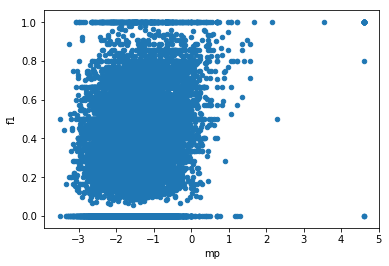

In [40]:
(pd.DataFrame({'dp': np.log(threshold_df_agg.user_distinct_products),
               'f1':threshold_df_agg.f1,
              'mp': threshold_df_agg.user_ump_logit})
 #.query('f1 < .999 and f1 > 0.0')
 #.eval('f1 = log(f1 / (1-f1))', inplace=False)
 .plot.scatter(x='mp', y='f1'))

In [139]:
f1df = pd.DataFrame({'dp': np.log(threshold_df_agg.user_distinct_products),
               'f1':threshold_df_agg.f1,
              'mp': threshold_df_agg.user_ump_logit})

In [140]:
f1x = f1df[['dp', 'mp']].values
f1y = f1df['f1'].values

In [150]:
f1scale = StandardScaler()

In [151]:
f1x = f1scale.fit_transform(f1x)

In [144]:
from sklearn.linear_model import LinearRegression

In [152]:
f1model = LinearRegression()

f1model.fit(f1x, f1y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [157]:
f1model.score(f1x, f1y)

0.033194171442887832

In [138]:
pearsonr(np.log(threshold_df_agg.user_distinct_products), threshold_df_agg.user_ump_logit)

(-0.74021554040671822, 0.0)

In [30]:
np.arange(0, 0, 0.01)

array([], dtype=float64)

In [18]:
df_test = df.loc[df.eval_set == 'test', ['order_id', 'product_id', 'user_distinct_products', 'model_prediction', 'p_not']].copy()
df_test['reorder_cutoff'] = best_reorder_cutoff[0] + best_reorder_cutoff[1] * np.log(df_test.user_distinct_products)
df_test['prediction'] = 1 * (df_test['model_prediction'] > df_test.reorder_cutoff)


In [65]:
test_df.prediction.mean()

0.14079389368571152

In [92]:
writenone_df = test_df.groupby('order_id').agg({'putnone': np.mean}).reset_index()

In [93]:
writenone_df['nonestring'] = ''
writenone_df.loc[writenone_df.putnone == 1, 'nonestring'] = 'None'


In [94]:
writenone_df.nonestring.describe()

count     75000
unique        2
top            
freq      61594
Name: nonestring, dtype: object

In [95]:
prediction_df = test_df.query('prediction == 1').copy()
prediction_df = prediction_df[['order_id', 'product_id']]

In [96]:
prediction_lists = prediction_df.groupby('order_id').agg(lambda x: " ".join(x.astype(str))).reset_index()
prediction_lists = prediction_lists.merge(writenone_df[['order_id', 'nonestring']], on='order_id', how='right')
prediction_lists['products'] = prediction_lists.product_id.fillna('')
prediction_lists['products'] = prediction_lists.products + " " + prediction_lists.nonestring

prediction_lists = prediction_lists[['order_id', 'products']]
prediction_lists.to_csv("submissions/rawpredictions_composite.csv", index=False)


In [98]:
prediction_lists.head()

,order_id,products
0,17,47766 38777 21463 13107
1,34,13176 21137 47792 47766 43504 39475 2596 18618...
2,137,41787 24852 25890 5134 38689 2326 23794
3,182,47209 39275 47672 33000 13629 41149 11520 9337...
4,257,49235 24852 27966 21137 45013 27104 4605 37646...
